[I 2023-09-22 20:54:03,683] A new study created in memory with name: no-name-a10ed745-00a3-49b5-8d6d-2949c5d025fa
C:\Users\USER\AppData\Local\Temp\ipykernel_24388\1656498672.py:101: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-3)
C:\Users\USER\AppData\Local\Temp\ipykernel_24388\1656498672.py:102: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.7)



Epoch 7: ReduceLROnPlateau reducing learning rate to 7.277245458681136e-06.

Epoch 11: ReduceLROnPlateau reducing learning rate to 7.277245458681137e-07.

Epoch 19: ReduceLROnPlateau reducing learning rate to 7.277245686054812e-08.


[I 2023-09-22 22:07:25,187] Trial 0 finished with value: 0.944844126701355 and parameters: {'learning_rate': 7.277245664053246e-05, 'dropout_rate': 0.4350336835392664, 'dense_units': 178}. Best is trial 0 with value: 0.944844126701355.


Epoch 1/20
105/105 [==============================] - 541s 5s/step - loss: 0.3499 - accuracy: 0.8382 - val_loss: 0.1827 - val_accuracy: 0.9269 - lr: 7.2772e-05
Epoch 2/20
105/105 [==============================] - 450s 4s/step - loss: 0.2071 - accuracy: 0.9194 - val_loss: 0.1451 - val_accuracy: 0.9484 - lr: 7.2772e-05
Epoch 3/20
105/105 [==============================] - 439s 4s/step - loss: 0.1917 - accuracy: 0.9191 - val_loss: 0.1280 - val_accuracy: 0.9484 - lr: 7.2772e-05
Epoch 4/20
105/105 [==============================] - 452s 4s/step - loss: 0.1692 - accuracy: 0.9365 - val_loss: 0.1250 - val_accuracy: 0.9496 - lr: 7.2772e-05
Epoch 5/20
105/105 [==============================] - 433s 4s/step - loss: 0.1762 - accuracy: 0.9278 - val_loss: 0.1319 - val_accuracy: 0.9520 - lr: 7.2772e-05
Epoch 6/20
105/105 [==============================] - 441s 4s/step - loss: 0.1611 - accuracy: 0.9353 - val_loss: 0.1188 - val_accuracy: 0.9496 - lr: 7.2772e-05
Epoch 7/20
105/105 [====================

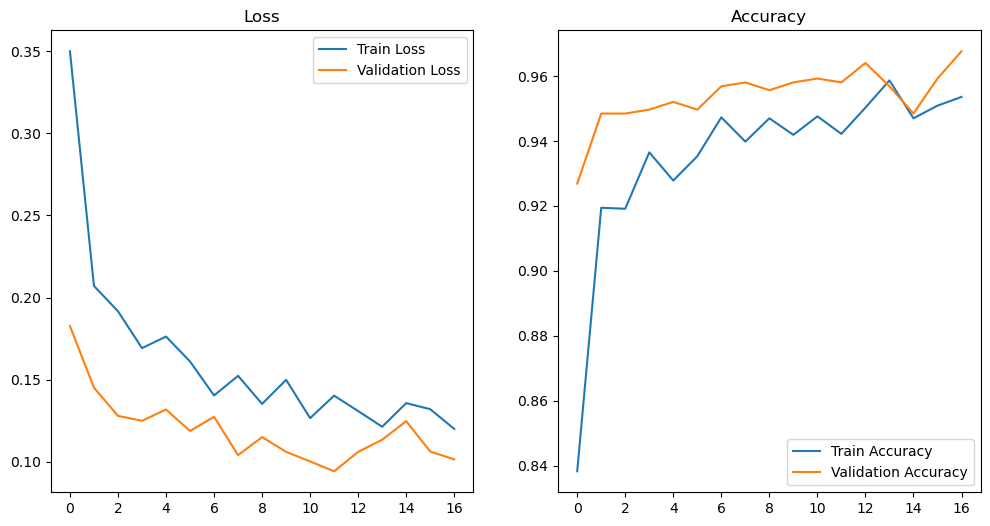

In [2]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import DenseNet121, NASNetLarge
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import optuna
# Set your data and category paths
Data = "C:/Users/USER/Test_VXXXX/dataset/train"
Data1 = "C:/Users/USER/Test_VXXXX/dataset/test"

Categories = ["NORMAL", "PNEUMONIA"]

img_size = 160

# Function to create training and testing data
def create_data(data_path, categories):
    data = []
    for category in categories:
        path = os.path.join(data_path, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)  # Load as color image
                new_array = cv2.resize(img_array, (img_size, img_size))
                data.append([new_array, class_num])
            except Exception as e:
                pass
    random.shuffle(data)
    return data

training_data = create_data(Data, Categories)
testing_data = create_data(Data1, Categories)

# Separate features and labels for training and testing
X_train = []
y_train = []
X_test = []
y_test = []

for features, label in training_data:
    X_train.append(features)
    y_train.append(label)

for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)

# Normalize and reshape data for both training and testing
X_train = np.array(X_train).reshape(-1, img_size, img_size, 3)  # Use 3 channels
X_train = X_train / 255.0

X_test = np.array(X_test).reshape(-1, img_size, img_size, 3)  # Use 3 channels
X_test = X_test / 255.0

y_train = to_categorical(y_train, num_classes=len(Categories))
y_test = to_categorical(y_test, num_classes=len(Categories))

# Split data into training and validation sets
X_train, x_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Create the base models
input_shape = (img_size, img_size, 3)
base_model_densenet = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
base_model_nasnet = NASNetLarge(weights="imagenet", include_top=False, input_shape=input_shape)

# Freeze the base models
for layer in base_model_densenet.layers:
    layer.trainable = False

for layer in base_model_nasnet.layers:
    layer.trainable = False

# Define callbacks
early_stopping = EarlyStopping(patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3, verbose=1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
)

# Define the hyperparameter search space
def objective(trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-3)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.7)
    dense_units = trial.suggest_int("dense_units", 64, 512)

    # Create the ensemble model with the suggested hyperparameters
    ensemble_model = build_ensemble_model(learning_rate, dropout_rate, dense_units)

    # Compile the model
    ensemble_model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train the model
    history = ensemble_model.fit(
        datagen.flow(X_train, y_train, batch_size=32, subset="training"),
        epochs=20,
        validation_data=datagen.flow(X_train, y_train, batch_size=32, subset="validation"),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # Evaluate the model on the validation data
    val_accuracy = history.history["val_accuracy"][-1]

    return val_accuracy

# Build the ensemble model with given hyperparameters
def build_ensemble_model(learning_rate, dropout_rate, dense_units):
    input_layer = Input(shape=input_shape)
    x_densenet = base_model_densenet(input_layer)
    x_nasnet = base_model_nasnet(input_layer)
    x = Concatenate()([GlobalAveragePooling2D()(x_densenet), GlobalAveragePooling2D()(x_nasnet)])
    x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation="relu")(x)
    output_layer = Dense(len(Categories), activation="softmax")(x)

    ensemble_model = Model(inputs=input_layer, outputs=output_layer)

    return ensemble_model

# Create a study object and optimize hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1)  # You can adjust the number of trials

# Get the best hyperparameters
best_learning_rate = study.best_params["learning_rate"]
best_dropout_rate = study.best_params["dropout_rate"]
best_dense_units = study.best_params["dense_units"]

# Build and compile the ensemble model with the best hyperparameters
best_model = build_ensemble_model(best_learning_rate, best_dropout_rate, best_dense_units)
best_model.compile(
    optimizer=Adam(learning_rate=best_learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the best model
history = best_model.fit(
    datagen.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=20,
    validation_data=datagen.flow(X_train, y_train, batch_size=32, subset="validation"),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate confusion matrix and classification report
confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print("Confusion Matrix:\n", confusion_mtx)
print("Classification Report:\n", classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()